In [ ]:
# https://curiousily.com/posts/intent-recognition-with-bert-using-keras-and-tensorflow-2/
!pip install transformers

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# text preprocessing
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model, model_from_json
# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/Multi-Task-W2V/data/'
#'Pos_neg_merged_data.csv', 'combine_pos_neg-v1'
data= pd.read_csv(folder_path + 'combine_pos_neg-v1.csv')
data.head()

,sentence,label,source
0,The price is reasonable and the service is great.,1,yelp
1,Was not happy.,0,amazon
2,VERY funny!,1,imdb
3,"I agree with Jessica, this movie is pretty bad.",0,imdb
4,I'm super pissd.,0,yelp


In [ ]:
data.tail()

,sentence,label,source
2995,If someone orders two tacos don't' you think i...,0,yelp
2996,I had high hopes for this place since the burg...,0,yelp
2997,I exchanged the sony ericson z500a for this an...,1,amazon
2998,Saw the movie today and thought it was a good ...,1,imdb
2999,The cashier was friendly and even brought the ...,1,yelp


In [ ]:
#Defining functions for Cleaning and Normalization of Data
import re
import string
def replace_url(string): # cleaning of URL
    text = re.sub(r'http\S+', 'LINK', string)
    return text


def replace_email(text):#Cleaning of Email related text
    line = re.sub(r'[\w\.-]+@[\w\.-]+','MAIL',str(text))
    return "".join(line)

def rep(text):#cleaning of non standard words
    grp = text.group(0)
    if len(grp) > 3:
        return grp[0:2]
    else:
        return grp# can change the value here on repetition
def unique_char(rep,sentence):
    convert = re.sub(r'(\w)\1+', rep, sentence) 
    return convert

def find_dollar(text):#Finding the dollar sign in the text
    line=re.sub(r'\$\d+(?:\.\d+)?','PRICE',text)
    return "".join(line)

def replace_emoji(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text) 

puncts = [':', ')', '(', '-', '!', '?', '|', ';', '$', '&', '/', '[', ']','ª',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']

def clean_text(text: str) -> str:
    text = str(text)
    for punct in puncts:
        if punct in text:
            text = text.replace(punct, f' ')
    return text
   
def replace_asterisk(text):
    text = re.sub("\*", 'ABUSE ', text)
    return text

def remove_duplicates(text):
    text = re.sub(r'\b(\w+\s*)\1{1,}', '\\1', text)
    return text
def remove_numbers(text):
    text = re.sub("(\s\d+)"," ",text) 
    return text
def change(text):
    if(text == ''):
        return text
  #calling the subfunctions in the cleaning function
    text = text.lower()
    text = replace_email(text)
    text = replace_url(text)
    text = unique_char(rep,text)
    #text = replace_asterisk(text)
    text = remove_duplicates(text)
    text = clean_text(text)
    text = remove_numbers(text)
    text = text.strip()
    return text

In [ ]:
data['clean_sentence'] = data['sentence'].apply(lambda x : change(x))

In [ ]:
data.head()

,sentence,label,source,clean_sentence
0,The price is reasonable and the service is great.,1,yelp,the price is reasonable and the service is great.
1,Was not happy.,0,amazon,was not happy.
2,VERY funny!,1,imdb,very funny
3,"I agree with Jessica, this movie is pretty bad.",0,imdb,"i agree with jessica, this movie is pretty bad."
4,I'm super pissd.,0,yelp,i'm super pissd.


In [ ]:
# drop duplicates
temp_data = data.drop_duplicates(subset=['clean_sentence'], keep='last')
temp_data = temp_data.dropna()
data = temp_data.reset_index(drop=True)
data.label.value_counts()

0    1491
1    1488
Name: label, dtype: int64

In [ ]:
final_df = data
final_df.tail()

,sentence,label,source,clean_sentence
2974,If someone orders two tacos don't' you think i...,0,yelp,if someone orders two tacos don't' you think i...
2975,I had high hopes for this place since the burg...,0,yelp,i had high hopes for this place since the burg...
2976,I exchanged the sony ericson z500a for this an...,1,amazon,i exchanged the sony ericson z500a for this an...
2977,Saw the movie today and thought it was a good ...,1,imdb,saw the movie today and thought it was a good ...
2978,The cashier was friendly and even brought the ...,1,yelp,the cashier was friendly and even brought the ...


In [ ]:
final_df.label.value_counts(), final_df.shape

(0    1491
 1    1488
 Name: label, dtype: int64, (2979, 4))

**Steps For Extracting Contexual Embeddings from Distilbert/BERT**

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, BertConfig
from transformers import DistilBertTokenizer, TFDistilBertModel

distil_bert = 'distilbert-base-uncased' # Name of the pretrained models
bert = 'bert-base-uncased'

#BERT 
tokenizer = BertTokenizer.from_pretrained(bert)
model = TFBertModel.from_pretrained(bert)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


**For Understanding Purpose**

In [ ]:
# obtain the 768-dim vector correpsoding to [CLS] which is a sentence vector
e = tokenizer.encode("Hello my dog is cute", add_special_tokens=False)
print(e)

input = tf.constant(e)[None, :]  # Batch size 1 
print(input)
print(type(input)) # shape: [1,8]

output = model(input)

print(type(output))
print(len(output))
print(output) #shape[1,8,768]

[7592, 2026, 3899, 2003, 10140]
tf.Tensor([[ 7592  2026  3899  2003 10140]], shape=(1, 5), dtype=int32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'transformers.modeling_tf_outputs.TFBaseModelOutputWithPooling'>
2
TFBaseModelOutputWithPooling(last_hidden_state=<tf.Tensor: shape=(1, 5, 768), dtype=float32, numpy=
array([[[-0.05852197,  0.45121658,  0.38024926, ..., -0.31962964,
          0.23802868,  0.35535392],
        [-0.73515904,  0.02028046,  0.32069477, ..., -0.20270441,
         -0.20234984,  0.33687302],
        [-0.6164801 ,  0.10205369,  0.15520775, ..., -0.39130968,
         -0.16932479,  0.51754975],
        [-0.79905194, -0.04866516,  0.1796481 , ..., -0.14961566,
         -0.0934305 ,  0.46574074],
        [-0.83175254, -0.07209262,  0.22768457, ..., -0.15934399,
         -0.087263  ,  0.21164113]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-4.64746267e-01,  1.10109545e-01,  8.65532160e-01,
         3.13073

In [ ]:
text = final_df.clean_sentence[2784]
print(text)
e = tokenizer.encode(text, add_special_tokens=False)
print(len(e))
print(e)
temp_split = tokenizer.tokenize(text)
print(len(temp_split))
print(temp_split)

they also now serve indian naan bread with hummus and some spicy pine nut sauce that was out of this world.
24
[2027, 2036, 2085, 3710, 2796, 6583, 2319, 7852, 2007, 14910, 7606, 1998, 2070, 25482, 7222, 17490, 12901, 2008, 2001, 2041, 1997, 2023, 2088, 1012]
24
['they', 'also', 'now', 'serve', 'indian', 'na', '##an', 'bread', 'with', 'hum', '##mus', 'and', 'some', 'spicy', 'pine', 'nut', 'sauce', 'that', 'was', 'out', 'of', 'this', 'world', '.']


In [ ]:
final_df.clean_text[2784]

'since when did you get so good again  transcontinental flights inh  what a pleasurerelief you were'

**Create function for Mapping Words to ids and Word Embeddings**

In [ ]:
# sentence wise contextual embeddings
def word_ids_embeddings(dataframe):
  word_ids = {} # index of words => word->ids, ex:'for'->2005, 
  word_embeddings = {} # word->embeddings 
  dummy_index = [] # if both tokenization lengths are not matching
  for i in tqdm(range(len(dataframe))):
    text = str(dataframe.clean_sentence[i])
    e = tokenizer.encode(text, add_special_tokens=False) # token ids
    text_token = tokenizer.tokenize(text)
    input = tf.constant(e)[None, :]  # Batch size 1 
    output = model(input)[0][0]
    if len(e) == len(output) == len(text_token):
      for j in range(len(e)):
        word_ids[text_token[j]] = e[j] # word->ids
        final_out = np.asarray(output[j]) # convert as numpy array
        word_embeddings[text_token[j]] = final_out # word->embeddings
    else:
      dummy_index.append(i) # if lengths are not matching
  return word_ids, word_embeddings, dummy_index

In [ ]:
# extract embeddings using above function
word_ids, word_embeddings, dummy_index = word_ids_embeddings(final_df)
len(word_ids), len(word_embeddings), len(dummy_index)

100%|██████████| 2979/2979 [10:49<00:00,  4.59it/s]


(5183, 5183, 0)

In [ ]:
# save ids words->ids as vocab.txt file
import os
for key, value in word_ids.items(): 
  #print(key, value[0])
  temp = key +" "+str(value)
  with open('vocab-v1.txt', 'a') as f1:
    f1.write(temp + os.linesep)

In [ ]:
# max vocab - len of vocab
max_vocab = []
index_of_words = word_ids
for key, value in word_embeddings.items():
  if key in index_of_words:
    idx = index_of_words[key]
    max_vocab.append(idx)

max(max_vocab) # 29591, 29659

29591

**Embeddings Matrix**

In [ ]:
# helper function to create embeddings matrix
def create_embedding_matrix(max_vocab, word_embeddings, word_index, embedding_dim):
    vocab_size = max(max_vocab) + 1  # Adding again 1 because of reserved 0 index 29567-all ids 
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, vector in word_embeddings.items():
      if word in word_index:
        idx = word_index[word] 
        #print(idx, word)
        embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
# crate embeddings matrix
embed_num_dims = 300 # 768, 300, 100
index_of_words = word_ids
embedd_matrix = create_embedding_matrix(max_vocab, word_embeddings, index_of_words, embed_num_dims)
embedd_matrix.shape

(29592, 300)

In [ ]:
# Embedding layer before the actual CNN
vocab_size = max(max_vocab) + 1
max_seq_len = 100
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

**Create Model**

In [ ]:
# Convolution
kernel_size = 3
filters = 256
num_classes =2
model_cnn = Sequential()
model_cnn.add(embedd_layer)
model_cnn.add(Conv1D(filters, kernel_size, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(num_classes, activation='softmax'))
model_cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          8877600   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 98, 256)           230656    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 514       
Total params: 9,174,562
Trainable params: 296,962
Non-trainable params: 8,877,600
_________________________________________________________________


In [ ]:
# Early stopping and path to save weights 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights_datasetv2_cnnv2.hdf5', verbose=1, save_best_only=True)

In [ ]:
final_df.head()

,sentence,label,source,clean_sentence
0,The price is reasonable and the service is great.,1,yelp,the price is reasonable and the service is great.
1,Was not happy.,0,amazon,was not happy.
2,VERY funny!,1,imdb,very funny
3,"I agree with Jessica, this movie is pretty bad.",0,imdb,"i agree with jessica, this movie is pretty bad."
4,I'm super pissd.,0,yelp,i'm super pissd.


**Split Dataset and Padding**

In [ ]:
# split dataset
X = final_df.clean_sentence
y = final_df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =42, shuffle=True)
print(X_train.shape)
print(X_test.shape)

(2383,)
(596,)


In [ ]:
X_train_tokenized = X_train.apply((lambda x: tokenizer.encode(x, add_special_tokens=False)))
X_test_tokenized = X_test.apply((lambda x: tokenizer.encode(x, add_special_tokens=False)))

In [ ]:
max_seq_len = 100
X_train_pad = pad_sequences(X_train_tokenized, maxlen = max_seq_len, padding='post')
X_test_pad = pad_sequences(X_test_tokenized, maxlen = max_seq_len, padding='post')
X_train_pad

array([[1996, 9855, 2003, ...,    0,    0,    0],
       [1045, 4149, 2023, ...,    0,    0,    0],
       [1999, 2755, 1010, ...,    0,    0,    0],
       ...,
       [1045, 2347, 1005, ...,    0,    0,    0],
       [2057, 2288, 1996, ...,    0,    0,    0],
       [2009, 1005, 1055, ...,    0,    0,    0]], dtype=int32)

In [ ]:
encoding = {'negative': 0, 'neutral': 1, 'positive': 2}
# Integer labels
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

**Model Training**

In [ ]:
# model training
batch_size = 4
epochs = 30

hist = model_cnn.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test), 
                 callbacks=[early_stopping, checkpointer])

Epoch 1/30
596/596 [==============================] - 8s 13ms/step - loss: 0.6794 - accuracy: 0.6518 - val_loss: 0.6185 - val_accuracy: 0.6695

Epoch 00001: val_loss improved from inf to 0.61855, saving model to weights_datasetv2_cnnv2.hdf5
Epoch 2/30
596/596 [==============================] - 8s 13ms/step - loss: 0.3789 - accuracy: 0.8375 - val_loss: 0.5354 - val_accuracy: 0.7852

Epoch 00002: val_loss improved from 0.61855 to 0.53544, saving model to weights_datasetv2_cnnv2.hdf5
Epoch 3/30
596/596 [==============================] - 8s 13ms/step - loss: 0.2395 - accuracy: 0.9048 - val_loss: 0.6987 - val_accuracy: 0.7466

Epoch 00003: val_loss did not improve from 0.53544
Epoch 4/30
596/596 [==============================] - 8s 13ms/step - loss: 0.1583 - accuracy: 0.9362 - val_loss: 0.4818 - val_accuracy: 0.8255

Epoch 00004: val_loss improved from 0.53544 to 0.48182, saving model to weights_datasetv2_cnnv2.hdf5
Epoch 5/30
596/596 [==============================] - 8s 13ms/step - loss:

**Save Model and Weights**

In [ ]:
# Save the model to disk
model_json = model_cnn.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("weights_datasetv2_cnnv2.hdf5")
print("Model Loaded")

# the optimiser
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model Loaded


In [ ]:
class_names = ['negative', 'positive']
predictions = loaded_model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
y_test1 = np.argmax(y_test, axis=1)
y_test1 = [class_names[x] for x in y_test1]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test1, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test1, predictions, average='micro') * 100))

Accuracy: 82.55%

F1 Score: 82.55


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 82.55


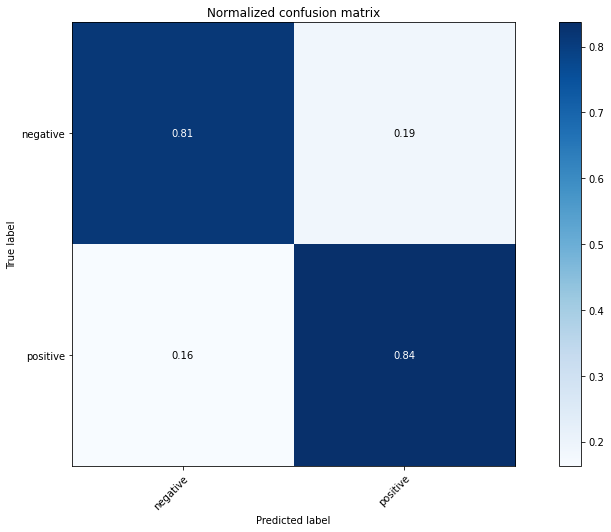

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(y_test1, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test1, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loaded_model.save("my_model2")

INFO:tensorflow:Assets written to: my_model2/assets


In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model("my_model2")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

In [ ]:
text = "it is a very bad day "
tokens= tokenizer.encode(text, add_special_tokens=False)
len1 = 100 - len(tokens)
for i in range(len1):
  tokens.append(0)

tokens = np.asarray(tokens)
tok = np.expand_dims(tokens, axis=0)
out = model_cnn.predict(tok)
predictions1 = np.argmax(out, axis=1)
pred1 = [class_names[pred] for pred in predictions1]
pred1

['negative']